In [40]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

load_dotenv() 

user = os.getenv("POSTGRES_USER")
pwd = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST")
port = os.getenv("POSTGRES_PORT")
db   = os.getenv("POSTGRES_DB")

engine = create_engine(f"postgresql+psycopg2://{user}:{pwd}@{host}:{port}/{db}")

full_data = pd.read_sql("""
    SELECT 
        a.*,
        p.gender,
        p.insurance_provider,
        p.date_of_birth,
        p.registration_date,         
        d.specialization,
        t.treatment_type,
        t.cost,                        
        b.amount,
        b.payment_method,
        b.payment_status
    FROM appointments a
    JOIN patients p ON a.patient_id = p.patient_id
    JOIN doctors d ON a.doctor_id = d.doctor_id
    LEFT JOIN treatments t ON a.appointment_id = t.appointment_id
    LEFT JOIN billing b ON t.treatment_id = b.treatment_id
""", engine)

full_data.head()


,appointment_id,patient_id,doctor_id,appointment_date,appointment_time,reason_for_visit,status,gender,insurance_provider,date_of_birth,registration_date,specialization,treatment_type,cost,amount,payment_method,payment_status
0,A001,P034,D009,2023-08-09,15:15:00,Therapy,Scheduled,F,WellnessCorp,1950-01-26,2023-06-18,Pediatrics,Chemotherapy,3941.97,3941.97,Insurance,Pending
1,A002,P032,D004,2023-06-09,14:30:00,Therapy,No-show,M,MedCare Plus,1981-01-08,2021-10-02,Pediatrics,MRI,4158.44,4158.44,Insurance,Paid
2,A003,P048,D004,2023-06-28,08:00:00,Consultation,Cancelled,M,PulseSecure,1983-03-24,2023-06-19,Pediatrics,MRI,3731.55,3731.55,Insurance,Paid
3,A004,P025,D006,2023-09-01,09:15:00,Consultation,Cancelled,M,HealthIndia,1966-08-14,2021-09-09,Pediatrics,MRI,4799.86,4799.86,Insurance,Failed
4,A005,P040,D003,2023-07-06,12:45:00,Emergency,No-show,M,PulseSecure,1972-05-30,2021-10-16,Pediatrics,ECG,582.05,582.05,Credit Card,Pending


In [41]:
patients = pd.read_sql("SELECT * FROM patients", engine)
doctors = pd.read_sql("SELECT * FROM doctors", engine)
appointments = pd.read_sql("SELECT * FROM appointments", engine)
treatments = pd.read_sql("SELECT * FROM treatments", engine)
billing = pd.read_sql("SELECT * FROM billing", engine)

In [42]:
patients.isnull().sum()
appointments.isnull().sum()
doctors.isnull().sum()
treatments.isnull().sum()
billing.isnull().sum()


bill_id           0
patient_id        0
treatment_id      0
bill_date         0
amount            0
payment_method    0
payment_status    0
dtype: int64

In [43]:
print("Patients:", patients.shape)
print("Doctors:", doctors.shape)
print("Appointments:", appointments.shape)
print("Treatments:", treatments.shape)
print("Billing:", billing.shape)

# Preview a few rows
patients.head()


Patients: (50, 11)
Doctors: (10, 8)
Appointments: (200, 7)
Treatments: (200, 6)
Billing: (200, 7)


,patient_id,first_name,last_name,gender,date_of_birth,contact_number,address,registration_date,insurance_provider,insurance_number,email
0,P001,David,Williams,F,1955-06-04,6939585183,789 Pine Rd,2022-06-23,WellnessCorp,INS840674,david.williams@mail.com
1,P002,Emily,Smith,F,1984-10-12,8228188767,321 Maple Dr,2022-01-15,PulseSecure,INS354079,emily.smith@mail.com
2,P003,Laura,Jones,M,1977-08-21,8397029847,321 Maple Dr,2022-02-07,PulseSecure,INS650929,laura.jones@mail.com
3,P004,Michael,Johnson,F,1981-02-20,9019443432,123 Elm St,2021-03-02,HealthIndia,INS789944,michael.johnson@mail.com
4,P005,David,Wilson,M,1960-06-23,7734463155,123 Elm St,2021-09-29,MedCare Plus,INS788105,david.wilson@mail.com


In [44]:
patients.info()
appointments['status'].value_counts()
billing['payment_status'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_id          50 non-null     object
 1   first_name          50 non-null     object
 2   last_name           50 non-null     object
 3   gender              50 non-null     object
 4   date_of_birth       50 non-null     object
 5   contact_number      50 non-null     int64 
 6   address             50 non-null     object
 7   registration_date   50 non-null     object
 8   insurance_provider  50 non-null     object
 9   insurance_number    50 non-null     object
 10  email               50 non-null     object
dtypes: int64(1), object(10)
memory usage: 4.4+ KB


payment_status
Pending    69
Failed     67
Paid       64
Name: count, dtype: int64

In [45]:
import plotly.express as px
import plotly.graph_objects as go


In [46]:
# Parse datetime
full_data['appointment_date'] = pd.to_datetime(full_data['appointment_date'])
full_data['weekday'] = full_data['appointment_date'].dt.day_name()
full_data['is_cancelled'] = full_data['status'] == 'Cancelled'


In [47]:
weekday_cancel = full_data.groupby('weekday')['is_cancelled'].mean().reset_index()

fig = px.bar(weekday_cancel, x='weekday', y='is_cancelled',
             title='Cancellation Rate by Day of Week',
             labels={'is_cancelled': 'Cancellation Rate'})
fig.show()


In [48]:
cost_by_specialization = full_data.groupby('specialization')['cost'].mean().reset_index()

fig = px.bar(cost_by_specialization.sort_values('cost', ascending=False),
             x='cost', y='specialization',
             orientation='h',
             title='Avg Treatment Cost by Doctor Specialization',
             labels={'cost': 'Average Cost'})
fig.show()



In [49]:
status_vs_payment = full_data.groupby(['status', 'payment_status']).size().reset_index(name='count')


In [50]:
import plotly.express as px

fig = px.bar(status_vs_payment,
             x='status',
             y='count',
             color='payment_status',
             barmode='group',
             title='Appointment Status vs Payment Status',
             labels={'count': 'Number of Appointments', 'status': 'Appointment Status'})

fig.show()


In [51]:
# Patients who have insurance
insured_patients = full_data[full_data['insurance_provider'].notna()]
total_by_provider = insured_patients.groupby('insurance_provider')['patient_id'].nunique().reset_index()
total_by_provider.columns = ['insurance_provider', 'total_patients']

insurance_success = full_data[
    (full_data['payment_method'] == 'Insurance') & 
    (full_data['payment_status'] == 'Paid')
]

paid_by_provider = insurance_success.groupby('insurance_provider')['patient_id'].nunique().reset_index()
paid_by_provider.columns = ['insurance_provider', 'paid_by_insurance']

insurance_efficiency = pd.merge(total_by_provider, paid_by_provider, on='insurance_provider', how='left')
insurance_efficiency['paid_by_insurance'] = insurance_efficiency['paid_by_insurance'].fillna(0)
insurance_efficiency['success_rate'] = insurance_efficiency['paid_by_insurance'] / insurance_efficiency['total_patients']



In [52]:
insurance_efficiency['success_pct'] = insurance_efficiency['success_rate'] * 100

# Step 2: Create a formatted label column as string + '%'
insurance_efficiency['label'] = insurance_efficiency['success_pct'].round(1).astype(str) + '%'


fig = px.bar(
    insurance_efficiency.sort_values('success_pct', ascending=False),
    x='insurance_provider',
    y='success_pct',
    text='label',  # ✅ This MUST match the string column
    title='Insurance Payment Success Rate by Provider',
    labels={'success_pct': 'Success Rate (%)'}
)

fig.update_traces(textposition='outside')
fig.update_layout(
    yaxis=dict(ticksuffix='%'),
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)

fig.show()


In [53]:
import pandas as pd
import plotly.express as px

# Filter to only COMPLETED + Insurance payment attempts
completed = full_data[full_data['status'] == 'Completed']
insurance_attempts = completed[completed['payment_method'] == 'Insurance']

# Group by insurance provider & treatment type
grouped = insurance_attempts.groupby(['insurance_provider', 'treatment_type'])

# Count total attempts and successful payments
summary = grouped.agg(
    total_attempts=('appointment_id', 'count'),
    successful=('payment_status', lambda x: (x == 'Paid').sum())
).reset_index()

# Calculate success rate
summary['success_rate'] = summary['successful'] / summary['total_attempts']
summary['label'] = (summary['success_rate'] * 100).round(1).astype(str) + '%'

# Plotly bubble chart
fig = px.scatter(summary,
                 x='insurance_provider',
                 y='treatment_type',
                 size='total_attempts',
                 color='success_rate',
                 color_continuous_scale='Blues',
                 size_max=50,
                 hover_name='insurance_provider',
                 text='label',
                 title='Insurance Coverage Success Rate by Treatment Type')

fig.update_traces(textposition='top center')
fig.update_layout(
    yaxis=dict(title='Treatment Type'),
    xaxis=dict(title='Insurance Provider'),
    coloraxis_colorbar=dict(title='Success Rate'),
    height=600
)

fig.show()


In [54]:
import pandas as pd
import plotly.express as px


# Preprocess

full_data['appointment_date'] = pd.to_datetime(full_data['appointment_date'], errors='coerce')
full_data['weekday'] = full_data['appointment_date'].dt.day_name()
full_data['is_cancelled'] = full_data['status'].isin(['Cancelled', 'No-show'])

# Group by specialization and weekday
heatmap_data = full_data.groupby(['specialization', 'weekday']).agg(
    total_appointments=('appointment_id', 'count'),
    cancellations=('is_cancelled', 'sum')
).reset_index()

# Calculate cancellation rate
heatmap_data['cancellation_rate'] = heatmap_data['cancellations'] / heatmap_data['total_appointments']

# Ensure weekday ordering
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data['weekday'] = pd.Categorical(heatmap_data['weekday'], categories=weekday_order, ordered=True)


# 👇 Sort based on categorical order to enforce display order in Plotly
heatmap_data = heatmap_data.sort_values('weekday')



# Plot heatmap
fig = px.density_heatmap(
    heatmap_data,
    x='weekday',
    y='specialization',
    z='cancellation_rate',
    text_auto='.1%',
    color_continuous_scale='Reds',
    title='Appointment Cancellation Rate by Day and Specialization'
)

fig.update_layout(
    yaxis=dict(title='Specialization'),
    xaxis=dict(title='Weekday'),
    coloraxis_colorbar=dict(
        title='Cancellation Rate (%)'  # ✅ FIXED legend label
    ),
    height=600
)

fig.update_traces(
    hovertemplate="Specialization: %{y}<br>Weekday: %{x}<br>Cancellation Rate: %{z:.1%}<extra></extra>"
)


fig.show()


In [71]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 1: Prep data
df = full_data.copy()
df = df[df['status'] != 'Scheduled']

df['is_no_show'] = df['status'].apply(lambda x: 1 if x == 'No-show' else 0)

# Step 2: Feature engineering
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df['appointment_date'] = pd.to_datetime(df['appointment_date'])
df['registration_date'] = pd.to_datetime(df['registration_date'])
df['day_of_week'] = df['appointment_date'].dt.dayofweek
df['lead_time'] = (df['appointment_date'] - df['registration_date']).dt.days
df['age'] = (df['appointment_date'] - df['date_of_birth']).dt.days // 365
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 35, 60, 100], labels=['Child', 'Young Adult', 'Adult', 'Senior'])


# Step 3: Select features and target
features = [
    'gender', 'reason_for_visit', 'specialization',
    'treatment_type', 'insurance_provider',
    'day_of_week', 'lead_time', 'age_group',
]

X = pd.get_dummies(df[features], drop_first=True)
y = df['is_no_show']

# Step 4: LOOCV with class_weight balanced
loo = LeaveOneOut()
rf = RandomForestClassifier(n_estimators=100, random_state=42)

y_true_rf = []
y_pred_rf = []
y_prob_rf = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf.fit(X_train, y_train)
    
    prob = rf.predict_proba(X_test)[:, 1][0]  # probability of class 1 (no-show)
    pred = rf.predict(X_test)[0]

    y_true_rf.append(y_test.values[0])
    y_pred_rf.append(pred)
    y_prob_rf.append(prob)

# Step 5: Default (threshold = 0.5) evaluation
print("🔵 Random Forest (default threshold 0.5) Results:")
print("Accuracy:", accuracy_score(y_true_rf, y_pred_rf))
print(classification_report(y_true_rf, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_true_rf, y_pred_rf))

# Step 6: Custom threshold evaluation
threshold = 0.3
y_pred_rf_custom = [1 if p > threshold else 0 for p in y_prob_rf]

print(f"\n🔵 Random Forest (custom threshold = {threshold}) Results:")
print("Accuracy:", accuracy_score(y_true_rf, y_pred_rf_custom))
print(classification_report(y_true_rf, y_pred_rf_custom))
print("Confusion Matrix:\n", confusion_matrix(y_true_rf, y_pred_rf_custom))




🔵 Random Forest (default threshold 0.5) Results:
Accuracy: 0.6442953020134228
              precision    recall  f1-score   support

           0       0.67      0.88      0.76        97
           1       0.48      0.21      0.29        52

    accuracy                           0.64       149
   macro avg       0.58      0.54      0.53       149
weighted avg       0.61      0.64      0.60       149

Confusion Matrix:
 [[85 12]
 [41 11]]

🔵 Random Forest (custom threshold = 0.3) Results:
Accuracy: 0.48322147651006714
              precision    recall  f1-score   support

           0       0.67      0.41      0.51        97
           1       0.36      0.62      0.45        52

    accuracy                           0.48       149
   macro avg       0.51      0.51      0.48       149
weighted avg       0.56      0.48      0.49       149

Confusion Matrix:
 [[40 57]
 [20 32]]


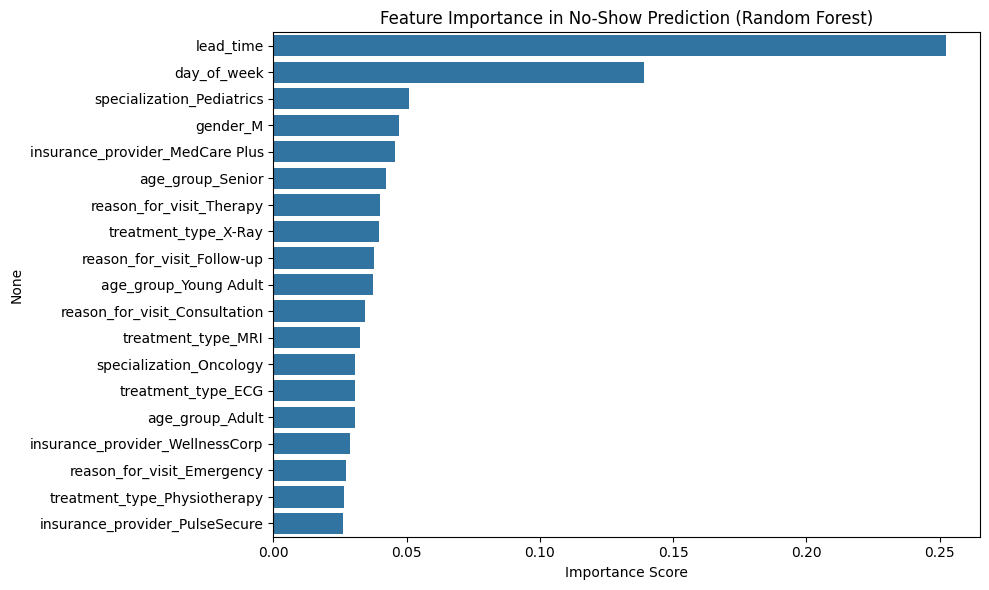

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Feature Importance in No-Show Prediction (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


In [66]:
from sklearn.linear_model import LogisticRegression

# Step 1: Reuse X and y from earlier (same features, same encoding)

# Step 2: LOOCV with Logistic Regression
logreg = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')

y_true_lr = []
y_pred_lr = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)

    y_true_lr.append(y_test.values[0])
    y_pred_lr.append(y_pred[0])

# Step 3: Evaluate Logistic Regression
print("\n🟠 Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_true_lr, y_pred_lr))
print(classification_report(y_true_lr, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_true_lr, y_pred_lr))



🟠 Logistic Regression Results:
Accuracy: 0.5167785234899329
              precision    recall  f1-score   support

           0       0.66      0.53      0.59        97
           1       0.36      0.50      0.42        52

    accuracy                           0.52       149
   macro avg       0.51      0.51      0.50       149
weighted avg       0.56      0.52      0.53       149

Confusion Matrix:
 [[51 46]
 [26 26]]


In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# Step 1: Prepare data
df = full_data.copy()
df = df[df['status'] != 'Scheduled']

df['is_no_show'] = df['status'].apply(lambda x: 1 if x == 'No-show' else 0)

# Step 2: Feature engineering
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df['appointment_date'] = pd.to_datetime(df['appointment_date'])
df['registration_date'] = pd.to_datetime(df['registration_date'])
df['day_of_week'] = df['appointment_date'].dt.dayofweek
df['lead_time'] = (df['appointment_date'] - df['registration_date']).dt.days
df['age'] = (df['appointment_date'] - df['date_of_birth']).dt.days // 365
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 35, 60, 100], labels=['Child', 'Young Adult', 'Adult', 'Senior'])


# Step 3: Select features and target
features = [
    'gender', 'reason_for_visit', 'specialization',
    'treatment_type', 'insurance_provider',
    'day_of_week', 'lead_time', 'age_group',
]

X = pd.get_dummies(df[features], drop_first=True)
y = df['is_no_show'].values

# Step 4: Set up LOOCV
loo = LeaveOneOut()

# Class imbalance fix: set scale_pos_weight = (# negative / # positive)
pos_weight = (y == 0).sum() / (y == 1).sum()

model = XGBClassifier(eval_metric='logloss', 
                      n_estimators=100, random_state=42, 
                      scale_pos_weight=pos_weight)

y_true_xgb = []
y_pred_xgb = []

# Step 5: Run LOOCV
for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    y_true_xgb.append(y_test[0])
    y_pred_xgb.append(pred[0])

# Step 6: Evaluate
print("🟢 XGBoost Classifier Results:")
print("Accuracy:", accuracy_score(y_true_xgb, y_pred_xgb))
print(classification_report(y_true_xgb, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_true_xgb, y_pred_xgb))


🟢 XGBoost Classifier Results:
Accuracy: 0.5906040268456376
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        97
           1       0.41      0.38      0.40        52

    accuracy                           0.59       149
   macro avg       0.54      0.54      0.54       149
weighted avg       0.59      0.59      0.59       149

Confusion Matrix:
 [[68 29]
 [32 20]]
